In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nbodykit.lab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from nbodykit import setup_logging
setup_logging()

data = pd.read_csv('../data/datasetcompleto.csv')

""" # Primero, dividimos en 60% (48% + 12%) y 40%
train_and_val, test = train_test_split(data, test_size=0.4, random_state=42)

# Ahora, dividimos el 60% en 48% y 12%
train, val = train_test_split(train_and_val, test_size=0.2, random_state=42)  # 0.2 * 60% = 12% """

# Model load

## Aux func

# Función para cargar datos desde un CSV
def load_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, 5:10].values
    #y = data.iloc[:, 12:16].values
    y = data.iloc[:, 12:14].values  #esto sólo carga el color
    return X, y

class QuantileLoss(torch.nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, yhat, y, tau):
        diff = yhat - y
        mask = (diff.ge(0).float() - tau).detach()
        return (mask * diff).mean()

Esto de abajo es mio

In [2]:
class customLossYan(nn.Module):
    def __init__(self, quantiles):
        super(customLossYan, self).__init__()
        self.quantiles = quantiles

    def forward(self, y_true, y_pred):
        losses = []
        for i,q in enumerate(self.quantiles):
            #print("predicción: ",y_pred)
            #print("verdad: ",y_true)
            errors = y_true[:,i] - y_pred[:,i]
            losses.append(
                torch.max((q - 1) * errors, q * errors)
            )
        loss = torch.mean(torch.stack(losses).sum(dim=0))
        return loss 

In [3]:
def augment(x, tau=None):
    if tau is None:
        tau = torch.zeros(x.size(0), 1).fill_(0.5)
    elif isinstance(tau, float):
        tau = torch.zeros(x.size(0), 1).fill_(tau)
    return torch.cat((x, (tau - 0.5) * 12), 1)

In [4]:
file_path = 'datasetcompleto.csv'  

## Model load

class aHaloToGalaxyModel(nn.Module):
    def __init__(self, input_size=4, output_size=5, hidden_dim=64):
        super(HaloToGalaxyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

Esto es mio


In [5]:
class HaloToGalaxyModel(nn.Module):
    def __init__(self, input_size=4, output_size=1, hidden_dim=64):
        super(HaloToGalaxyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [6]:
data = pd.read_csv(file_path)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
X = data.iloc[:, 5:10].values
#y = data.iloc[:, 12:16].values
y_smass = data.iloc[:, 12].values  #esto sólo carga la masa
y_smass = torch.tensor(y_smass, dtype=torch.float32).unsqueeze(1)

y_smass = y_smass.repeat(1, 3)

hidden_dim = 100 #tamaño de las capas ocultas

quantiles = [0.25, 0.5, 0.75]
quantiles2 = [0.25, 0.5, 0.75,0.25, 0.5, 0.75]
quantiles4 = [0.25, 0.5, 0.75,0.25, 0.5, 0.75,0.25, 0.5, 0.75,0.25, 0.5, 0.75]

model_smass = HaloToGalaxyModel(X.shape[1], len(quantiles), hidden_dim).to(device)
model_smass.load_state_dict(torch.load('StellarMass.pth'))

optimizer = torch.optim.AdamW(model_smass.parameters(), lr=1e-3, weight_decay=1e-2)
#optimizer.load_state_dict(torch.load('StellarMass.pth'))

/tmp/ipykernel_61954/341626595.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_smass.load_state_dict(torch.load('StellarMass.pth'))


In [9]:
y_color = data.iloc[:, 13].values  #esto sólo carga el color
y_color = torch.tensor(y_color, dtype=torch.float32).unsqueeze(1)
y_color = y_color.repeat(1,3)

y_smass_color = torch.cat((y_smass, y_color), dim=1)

model_smass_color = HaloToGalaxyModel(X.shape[1], len(quantiles2), hidden_dim).to(device)

model_smass_color.load_state_dict(torch.load('masaycolor.pth'))

optimizer = torch.optim.AdamW(model_smass_color.parameters(), lr=1e-3, weight_decay=1e-2)

/tmp/ipykernel_61954/2548561704.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_smass_color.load_state_dict(torch.load('masaycolor.pth'))


In [10]:
model_color = HaloToGalaxyModel(X.shape[1], len(quantiles), hidden_dim).to(device)

model_color.load_state_dict(torch.load('color1.pth'))

optimizer = torch.optim.AdamW(model_color.parameters(), lr=1e-3, weight_decay=1e-2)

/tmp/ipykernel_61954/4169783595.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_color.load_state_dict(torch.load('color1.pth'))


In [11]:
y_all = data.iloc[:, 12:16].values  #esto sólo carga la masa
y_radio = data.iloc[:, 14].values #radio
y_radio = torch.tensor(y_radio, dtype=torch.float32).unsqueeze(1)
y_sSFR = data.iloc[:, 15].values #sSFR 
y_sSFR = torch.tensor(y_sSFR, dtype=torch.float32).unsqueeze(1)

y_radio = y_radio.repeat(1,3)
y_sSFR = y_sSFR.repeat(1,3)

y_all = torch.cat((y_smass, y_color,y_radio,y_sSFR),dim=1)

model_all = HaloToGalaxyModel(X.shape[1], len(quantiles4), hidden_dim).to(device)

model_all.load_state_dict(torch.load('todos.pth'))

optimizer = torch.optim.AdamW(model_all.parameters(), lr=1e-3, weight_decay=1e-2)

/tmp/ipykernel_61954/3944336662.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_all.load_state_dict(torch.load('todos.pth'))


### Model predict

In [12]:
train_dev, test = train_test_split(data, test_size=0.15, random_state=42)

In [13]:
train_dev.shape, test.shape

((148567, 16), (26218, 16))

In [14]:
X_test = test.iloc[:, 5:10].values

'''
y_smass = test.iloc[:, 12].values
y_smass = y_smass.reshape(-1, 1)
y_color = test.iloc[:, 13].values
y_color = y_color.reshape(-1, 1)
y_smass_color = test.iloc[:, 12:14].values
y_smass_color = y_smass_color.reshape(-2, 2)
y_all = test.iloc[:, 12:16].values
y_all = y_all.reshape(-4, 4)'''

'\ny_smass = test.iloc[:, 12].values\ny_smass = y_smass.reshape(-1, 1)\ny_color = test.iloc[:, 13].values\ny_color = y_color.reshape(-1, 1)\ny_smass_color = test.iloc[:, 12:14].values\ny_smass_color = y_smass_color.reshape(-2, 2)\ny_all = test.iloc[:, 12:16].values\ny_all = y_all.reshape(-4, 4)'

In [15]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [16]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
'''
y_smass = torch.tensor(y_smass, dtype=torch.float32)
y_color = torch.tensor(y_color, dtype=torch.float32)
y_smass_color = torch.tensor(y_smass_color, dtype=torch.float32)
y_all = torch.tensor(y_all, dtype=torch.float32)'''

'\ny_smass = torch.tensor(y_smass, dtype=torch.float32)\ny_color = torch.tensor(y_color, dtype=torch.float32)\ny_smass_color = torch.tensor(y_smass_color, dtype=torch.float32)\ny_all = torch.tensor(y_all, dtype=torch.float32)'

In [17]:
model_smass.eval()
with torch.no_grad():
    #taus = torch.rand(X_test.size(0), 1)
    #augmented_x = augment(X_test, taus).to(device)
    #print(augmented_x)
    
    y_pred_smass = model_smass(X_test)
    y_pred_smass = y_pred_smass[:,1].unsqueeze(1)

print(y_pred_smass)

tensor([[-6.2853],
        [-4.8599],
        [-4.9689],
        ...,
        [-5.7967],
        [-3.4570],
        [-4.6674]], device='cuda:0')


In [18]:
model_color.eval()
with torch.no_grad():
    #taus = torch.rand(X_test.size(0), 1)
    #augmented_x = augment(X_test, taus)
    
    y_pred_color = model_color(X_test)
    y_pred_color = y_pred_color[:,1].unsqueeze(1)

print(y_pred_color)

tensor([[0.1873],
        [0.2992],
        [0.2214],
        ...,
        [0.2563],
        [0.5997],
        [0.3429]], device='cuda:0')


In [19]:
model_smass_color.eval()
with torch.no_grad():
    #taus = torch.rand(X_test.size(0), 1)
    #augmented_x = augment(X_test, taus)
    
    y_pred_smass_color = model_smass_color(X_test)
    y_pred_smass_color1 = y_pred_smass_color[:,1].unsqueeze(1)
    y_pred_smass_color2 = y_pred_smass_color[:,4].unsqueeze(1)
    y_pred_smass_color = torch.cat((y_pred_smass_color1,y_pred_smass_color2),dim=1)
print(y_pred_smass_color)

tensor([[3.7926, 1.5568],
        [4.5638, 1.5204],
        [4.2747, 1.6262],
        ...,
        [4.1250, 1.6632],
        [6.0891, 1.5233],
        [4.8662, 1.5610]], device='cuda:0')


In [20]:
model_all.eval()
with torch.no_grad():
    #taus = torch.rand(X_test.size(0), 1)
    #augmented_x = augment(X_test, taus)
    
    y_pred_all = model_all(X_test)
    y_pred_all1 = y_pred_all[:,1].unsqueeze(1)
    y_pred_all2 = y_pred_all[:,4].unsqueeze(1)
    y_pred_all3 = y_pred_all[:,7].unsqueeze(1)
    y_pred_all4 = y_pred_all[:,10].unsqueeze(1)
    y_pred_all = torch.cat((y_pred_all1,y_pred_all2,y_pred_all3,y_pred_all4),dim=1)

print(y_pred_all)

tensor([[  2.9647,   1.4900,   1.4709, -19.3170],
        [  3.6639,   1.2555,   1.3222, -27.9792],
        [  3.8699,   0.6349,   1.1446, -16.6758],
        ...,
        [  3.4608,   0.9242,   1.0403, -17.0275],
        [  8.1574,   1.5130,   0.5430, -21.9711],
        [  5.2318,   0.9945,   0.8449, -17.5298]], device='cuda:0')


### Dataframe constr

In [21]:
y_pred_smass_color_union = torch.cat((y_pred_smass,y_pred_color), dim=1)
y_pred_all = y_pred_all[:,:2]

print(y_pred_smass_color_union.shape)
print(y_pred_all.shape)

torch.Size([26218, 2])
torch.Size([26218, 2])


In [22]:
df_smass_color_joint = pd.DataFrame(y_pred_smass_color, columns=['stellar_mass', 'color_g_i'])
df_smass_color_union = pd.DataFrame(y_pred_smass_color_union, columns=['stellar_mass', 'color_g_i'])
df_smass_color_all = pd.DataFrame(y_pred_all, columns=['stellar_mass', 'color_g_i'])

df_smass_color_joint.index = test.index
df_smass_color_union.index = test.index
df_smass_color_all.index = test.index

In [23]:
df_smass_color_joint = pd.concat([test[['X_h', 'Y_h', 'Z_h']], df_smass_color_joint], axis=1)
df_smass_color_union = pd.concat([test[['X_h', 'Y_h', 'Z_h']], df_smass_color_union], axis=1)
df_smass_color_all = pd.concat([test[['X_h', 'Y_h', 'Z_h']], df_smass_color_all], axis=1)

# Power spectrum

In [24]:
def tracers_definer(df):
    tracers = {
        1: df[(df['color_g_i'] > 1.05) & (df['stellar_mass'].between(9.5, 10.5))],
        2: df[(df['color_g_i'] > 1.05) & (df['stellar_mass'] > 10.5)],
        3: df[(df['color_g_i'].between(0.80, 1.05)) & (df['stellar_mass'] <= 9.5)],
        4: df[(df['color_g_i'].between(0.80, 1.05)) & (df['stellar_mass'].between(9.5, 10.5))],
        5: df[(df['color_g_i'].between(0.80, 1.05)) & (df['stellar_mass'] > 10.5)],
        6: df[(df['color_g_i'] <= 0.80) & (df['stellar_mass'] <= 9.5)],
        7: df[(df['color_g_i'] <= 0.80) & (df['stellar_mass'].between(9.5, 10.5))]
    }
    return tracers

In [25]:
tracers = tracers_definer(test)
tracers_smass_color_joint = tracers_definer(df_smass_color_joint)
tracers_smass_color_union = tracers_definer(df_smass_color_union)
tracers_smass_color_all = tracers_definer(df_smass_color_all)

In [26]:
# Verificar el número de objetos en cada trazador
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers[i])} objetos')


Trazador 1: 1497 objetos
Trazador 2: 1942 objetos
Trazador 3: 1777 objetos
Trazador 4: 2300 objetos
Trazador 5: 482 objetos
Trazador 6: 11172 objetos
Trazador 7: 6908 objetos


In [27]:
# Verificar el número de objetos en cada trazador
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers_smass_color_joint[i])} objetos')


Trazador 1: 4 objetos
Trazador 2: 11 objetos
Trazador 3: 428 objetos
Trazador 4: 0 objetos
Trazador 5: 0 objetos
Trazador 6: 129 objetos
Trazador 7: 0 objetos


In [28]:
# Verificar el número de objetos en cada trazador
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers_smass_color_union[i])} objetos')


Trazador 1: 0 objetos
Trazador 2: 0 objetos
Trazador 3: 8 objetos
Trazador 4: 0 objetos
Trazador 5: 0 objetos
Trazador 6: 26208 objetos
Trazador 7: 0 objetos


In [29]:
# Verificar el número de objetos en cada trazador
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers_smass_color_all[i])} objetos')


Trazador 1: 13 objetos
Trazador 2: 29 objetos
Trazador 3: 4548 objetos
Trazador 4: 0 objetos
Trazador 5: 0 objetos
Trazador 6: 8029 objetos
Trazador 7: 0 objetos


In [30]:
# Función para calcular el espectro de potencia de un trazador dado
def calculate_power_spectrum(tracer_df):
    # Obtener posiciones de los halos
    positions = tracer_df[['X_h', 'Y_h', 'Z_h']].values #Para el original deben ser los de las galaxias reales
    # Crear un catálogo de nbodykit con las posiciones
    cat = ArrayCatalog({'Position': positions}, BoxSize=[205.0, 205.0, 205.0])
    # Convertir el catálogo a una malla
    mesh = cat.to_mesh(Nmesh=256, window='tsc')
    # Calcular el espectro de potencia 1D
    r = FFTPower(mesh, mode='1d')
    power = r.power
    # Obtener los valores de k y P(k)
    k = power['k']
    pk = power['power'].real - power.attrs['shotnoise']
    return k, pk

In [31]:
# Calcular los espectros de potencia para cada trazador
power_spectra = {}
for alpha, df in tracers.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra[alpha] = (k, pk)

/tmp/ipykernel_61954/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000204.30 ]   0: 07-31 00:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 1497 
[ 000204.43 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 1497 out of 1497 objects to mesh
[ 000204.43 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 1497 out of 1497 objects to mesh
[ 000204.43 ]   0: 07-31 00:05  CatalogMesh     INFO     mean particles per cell is 8.92282e-05
[ 000204.44 ]   0: 07-31 00:05  CatalogMesh     INFO     sum is 1497 
[ 000204.45 ]   0: 07-31 00:05  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000204.58 ]   0: 07-31 00:05  CatalogMesh     INFO     field: (ArrayCatalog(size=1497) as CatalogMesh) painting done
[ 000205.10 ]   0: 07-31 00:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 1942 
[ 000205.20 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 1942 out of 1942 objects to 

In [32]:
# Calcular los espectros de potencia para cada trazador
power_spectra_joint = {}
for alpha, df in tracers_smass_color_joint.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra_joint[alpha] = (k, pk)

/tmp/ipykernel_61954/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000209.74 ]   0: 07-31 00:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 4 
[ 000209.84 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 4 out of 4 objects to mesh
[ 000209.85 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 4 out of 4 objects to mesh
[ 000209.85 ]   0: 07-31 00:05  CatalogMesh     INFO     mean particles per cell is 2.38419e-07
[ 000209.85 ]   0: 07-31 00:05  CatalogMesh     INFO     sum is 4 
[ 000209.86 ]   0: 07-31 00:05  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000210.00 ]   0: 07-31 00:05  CatalogMesh     INFO     field: (ArrayCatalog(size=4) as CatalogMesh) painting done
[ 000210.50 ]   0: 07-31 00:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 11 
[ 000210.60 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 11 out of 11 objects to mesh
[ 000210.61 ]   0: 07-

In [33]:
# Calcular los espectros de potencia para cada trazador
power_spectra_union = {}
for alpha, df in tracers_smass_color_union.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra_union[alpha] = (k, pk)

/tmp/ipykernel_61954/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000214.77 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 0 out of 0 objects to mesh
[ 000214.77 ]   0: 07-31 00:05  CatalogMesh     INFO     mean particles per cell is 0
[ 000214.77 ]   0: 07-31 00:05  CatalogMesh     INFO     sum is 0 
[ 000214.78 ]   0: 07-31 00:05  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000214.92 ]   0: 07-31 00:05  CatalogMesh     INFO     field: (ArrayCatalog(size=0) as CatalogMesh) painting done
[ 000215.48 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 0 out of 0 objects to mesh
[ 000215.48 ]   0: 07-31 00:05  CatalogMesh     INFO     mean particles per cell is 0
[ 000215.48 ]   0: 07-31 00:05  CatalogMesh     INFO     sum is 0 
[ 000215.49 ]   0: 07-31 00:05  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000215.62 ]   0: 07-31 00:05  Catalo

In [34]:
# Calcular los espectros de potencia para cada trazador
power_spectra_all = {}
for alpha, df in tracers_smass_color_all.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra_all[alpha] = (k, pk)

/tmp/ipykernel_61954/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000219.72 ]   0: 07-31 00:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 13 
[ 000219.82 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 13 out of 13 objects to mesh
[ 000219.82 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 13 out of 13 objects to mesh
[ 000219.83 ]   0: 07-31 00:05  CatalogMesh     INFO     mean particles per cell is 7.7486e-07
[ 000219.83 ]   0: 07-31 00:05  CatalogMesh     INFO     sum is 13 
[ 000219.84 ]   0: 07-31 00:05  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000219.97 ]   0: 07-31 00:05  CatalogMesh     INFO     field: (ArrayCatalog(size=13) as CatalogMesh) painting done
[ 000220.49 ]   0: 07-31 00:05  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 29 
[ 000220.59 ]   0: 07-31 00:05  CatalogMesh     INFO     painted 29 out of 29 objects to mesh
[ 000220.59 ]   

In [35]:
# Función para calcular los valores de sigma² para cada trazador
def calculate_sigma(tracer_df, pk):
    # Número de trazadores
    n_alpha = len(tracer_df)
    # Volumen de la caja
    volume = 205.0**3
    # Densidad numérica promedio
    n_bar = n_alpha / volume
    k_values = pk[0]
    p_values = pk[1]
    # Delta k (diferencia entre valores consecutivos de k)
    delta_k = k_values[1] - k_values[0]
    # Volumen en el espacio k
    V_k = 4 * np.pi * k_values**2 * delta_k / (2 * np.pi)**3
    # Calcular sigma²
    sigma2_alpha_i = (2 / V_k) * ((1 + n_bar * p_values) / (n_bar * p_values))**2
    return sigma2_alpha_i

In [36]:
# Calcular los valores de sigma² para cada trazador
sigma_values_joint = {}
for alpha, df in tracers_smass_color_joint.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra_joint[alpha])
    sigma_values_joint[alpha] = sigma2_alpha_i

In [37]:
# Calcular los valores de sigma² para cada trazador
sigma_values_union = {}
for alpha, df in tracers_smass_color_union.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra_union[alpha])
    sigma_values_union[alpha] = sigma2_alpha_i

In [38]:
# Calcular los valores de sigma² para cada trazador
sigma_values_all = {}
for alpha, df in tracers_smass_color_all.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra_all[alpha])
    sigma_values_all[alpha] = sigma2_alpha_i

In [39]:
# Calcular los valores de sigma² para cada trazador
sigma_values = {}
for alpha, df in tracers.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra[alpha])
    sigma_values[alpha] = sigma2_alpha_i

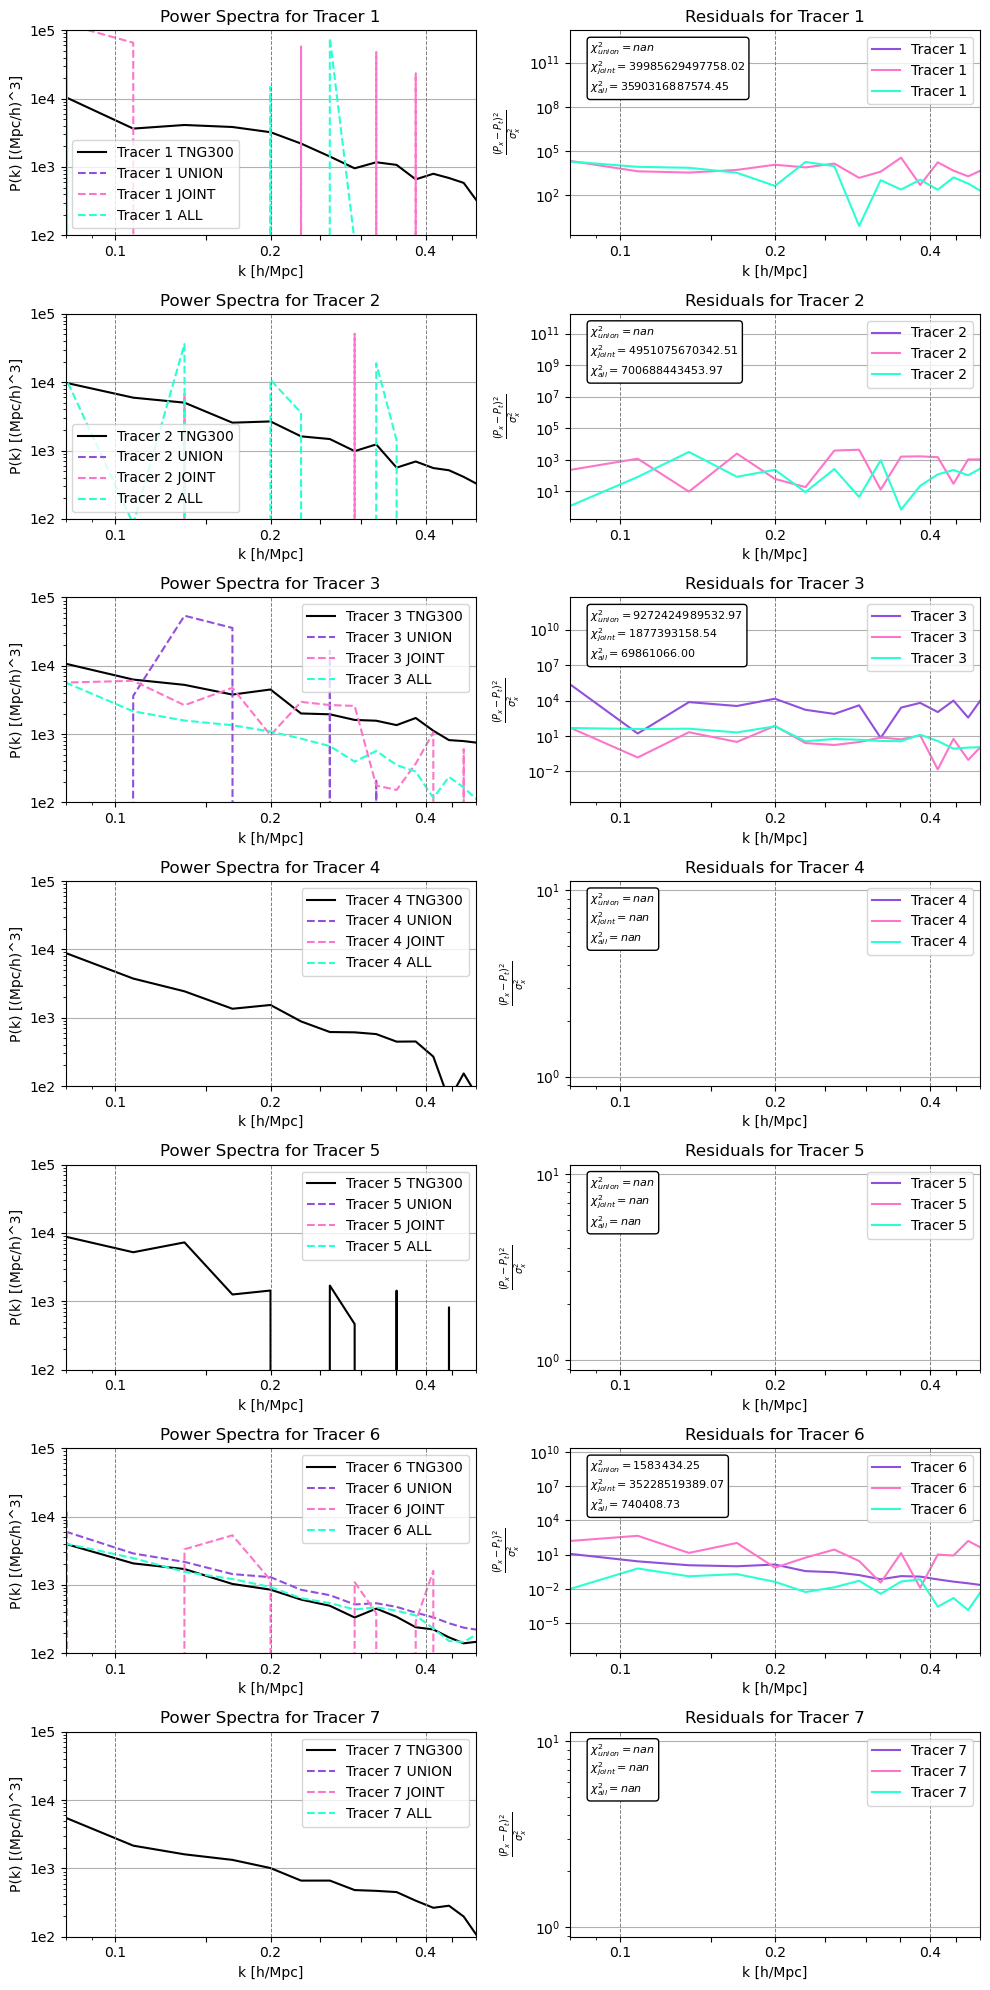

In [40]:
# Crear una figura grande con subgráficos organizados en una cuadrícula
fig, axs = plt.subplots(7, 2, figsize=(10, 20), facecolor='white')

for i, alpha in enumerate(range(1, 8)):
    # Subgráfico 1: P(k) vs k
    k, pk_tng300 = power_spectra[alpha]
    k_union, pk_union = power_spectra_union[alpha]
    k_joint, pk_joint = power_spectra_joint[alpha]
    k_all, pk_all = power_spectra_all[alpha]
    
    axs[i, 0].plot(k, pk_tng300, label=f'Tracer {alpha} TNG300', color='#000000')
    axs[i, 0].plot(k_union, pk_union, label=f'Tracer {alpha} UNION', linestyle='--', color='#924fdc')
    axs[i, 0].plot(k_joint, pk_joint, label=f'Tracer {alpha} JOINT', linestyle='--', color='#fd75ca')
    axs[i, 0].plot(k_all, pk_all, label=f'Tracer {alpha} ALL', linestyle='--', color='#2bffd2')
    
    axs[i, 0].set_xlabel('k [h/Mpc]')
    axs[i, 0].set_ylabel('P(k) [(Mpc/h)^3]')
    axs[i, 0].set_xscale('log')
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_title(f'Power Spectra for Tracer {alpha}')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    # Establecer los límites de los ejes
    axs[i, 0].set_xlim(0.08, 0.5)
    axs[i, 0].set_ylim(1e2, 1e5)

    # Establecer los ticks en los ejes
    axs[i, 0].set_xticks([0.1, 0.2, 0.4])
    axs[i, 0].set_xticklabels(['0.1', '0.2', '0.4'])
    axs[i, 0].set_yticks([1e2, 1e3, 1e4, 1e5])
    axs[i, 0].set_yticklabels(['1e2', '1e3', '1e4', '1e5'])
    
    # Controlar el formato de los ticks en el eje x usando MaxNLocator
    axs[i, 0].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    
    axs[i, 0].grid(False, which='both', axis='x')
    
    for tick in [0.1, 0.2, 0.4]:
        axs[i, 0].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)

    sigma2_alpha_i = sigma_values[alpha]

    residual_union = (pk_union - pk_tng300)**2 / sigma2_alpha_i
    residual_joint = (pk_joint - pk_tng300)**2 / sigma2_alpha_i
    residual_all = (pk_all - pk_tng300)**2 / sigma2_alpha_i
    axs[i, 1].plot(k_union, residual_union, label=f'Tracer {alpha}', color='#924fdc')
    axs[i, 1].plot(k_joint, residual_joint, label=f'Tracer {alpha}', color='#fd75ca')
    axs[i, 1].plot(k_all, residual_all, label=f'Tracer {alpha}', color='#2bffd2')
    

    
    chi2_value_union = np.sum(residual_union)
    chi2_value_joint = np.sum(residual_joint)
    chi2_value_all = np.sum(residual_all)
    
    # Añadir el valor de chi cuadrado como texto en el gráfico
    table_str = (
        r'$\chi^2_{union} = ' + f'{chi2_value_union:.2f}$' '\n'
        r'$\chi^2_{joint} = ' + f'{chi2_value_joint:.2f}$' '\n'
        r'$\chi^2_{all} = ' + f'{chi2_value_all:.2f}$'
    )
    axs[i, 1].text(0.05, 0.95, table_str, transform=axs[i, 1].transAxes, fontsize= 8, 
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    axs[i, 1].set_xlabel('k [h/Mpc]')
    axs[i, 1].set_ylabel(r'$\frac{(P_x - P_t)^2}{\sigma_x^2}$')
    axs[i, 1].set_xscale('log')
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_title(f'Residuals for Tracer {alpha}')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

    axs[i, 1].set_xlim(0.08, 0.5)

    axs[i, 1].set_xticks([0.1, 0.2, 0.4])
    axs[i, 1].set_xticklabels(['0.1', '0.2', '0.4'])

    axs[i, 1].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    
    axs[i, 1].grid(False, which='both', axis='x')
    
    for tick in [0.1, 0.2, 0.4]:
        axs[i, 1].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()


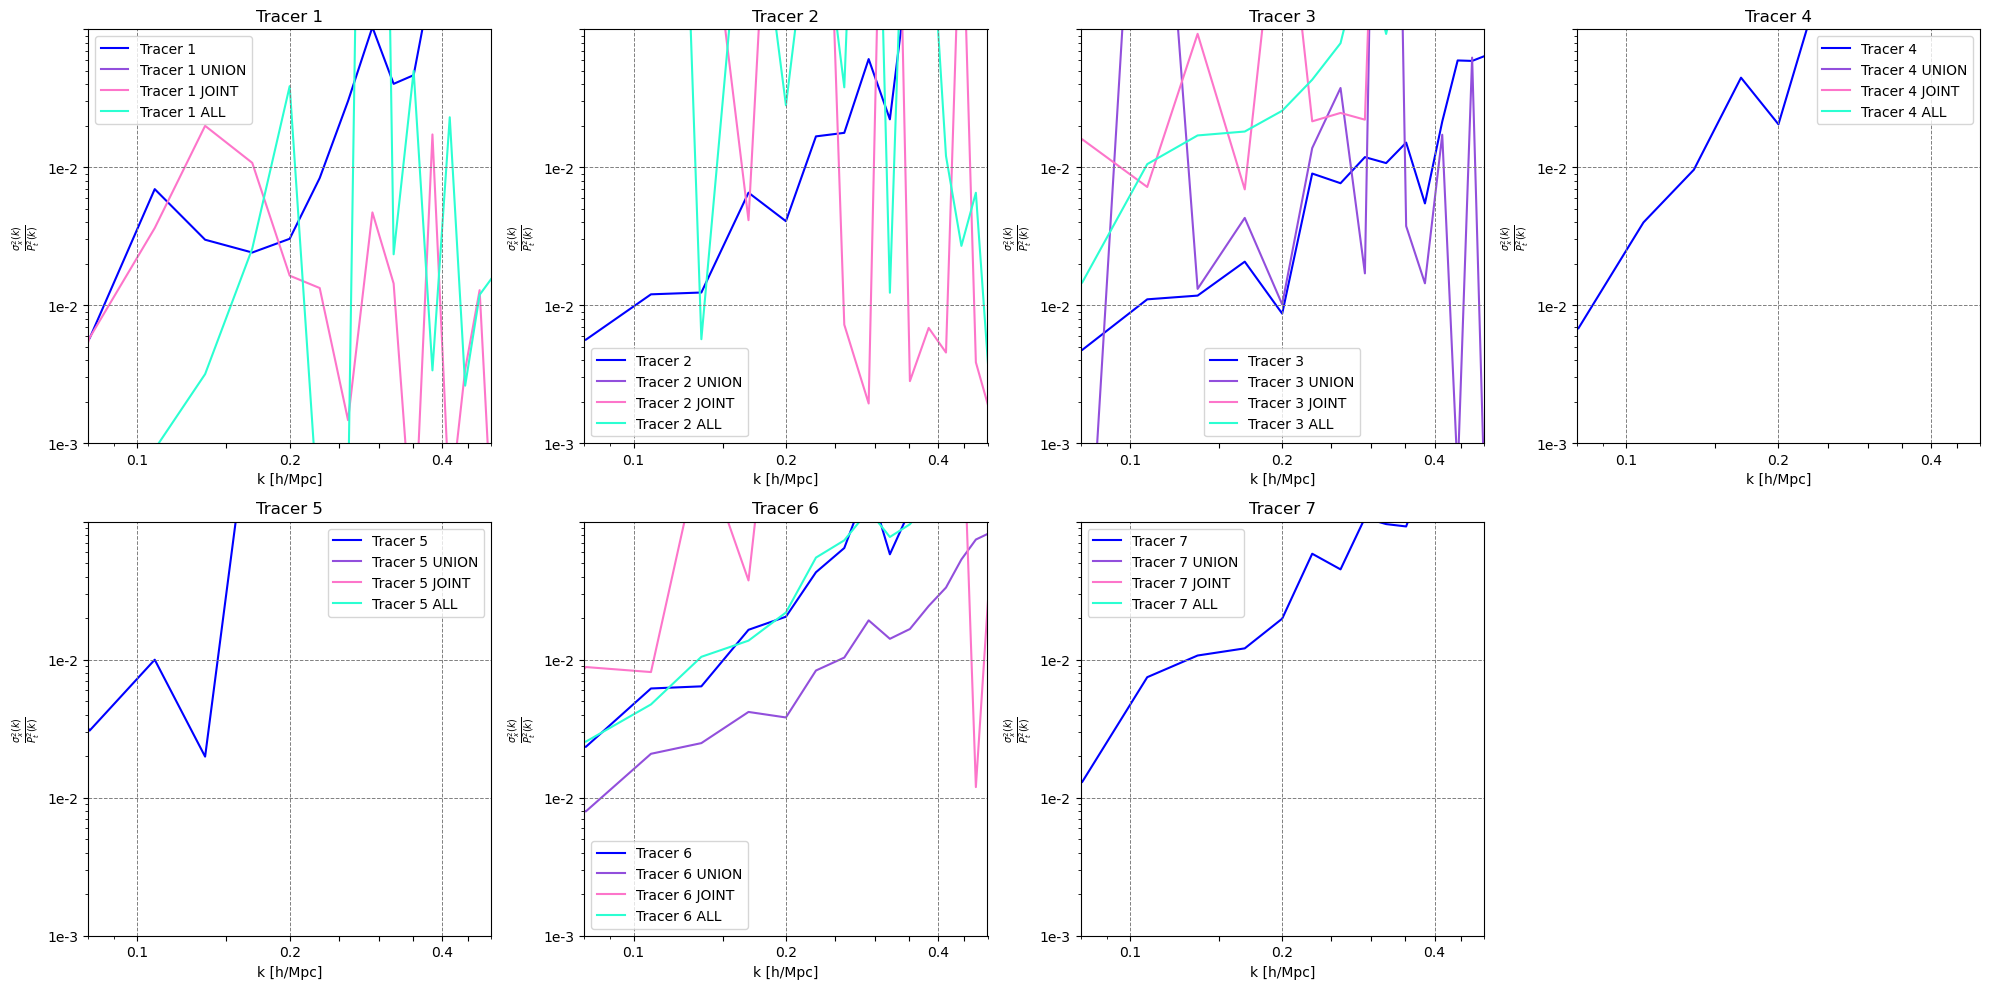

In [41]:
# Datos adicionales de ejemplo para otras líneas
additional_data = {
    'Extra 1': (np.logspace(-2, 1, 100), np.random.uniform(1e-1, 1e-3, 100)),
    'Extra 2': (np.logspace(-2, 1, 100), np.random.uniform(1e-1, 1e-3, 100)),
    'Extra 3': (np.logspace(-2, 1, 100), np.random.uniform(1e-1, 1e-3, 100)),
}

# Crear una figura grande con subgráficos organizados en una cuadrícula de 2 filas y 4 columnas
fig, axs = plt.subplots(2, 4, figsize=(20, 10), facecolor='white')

for i, alpha in enumerate(range(1, 8)):
    row, col = divmod(i, 4)  # Calcular la fila y la columna del subgráfico actual
    k, pk_tng300 = power_spectra[alpha]
    k_union, pk_union = power_spectra_union[alpha]
    k_joint, pk_joint = power_spectra_joint[alpha]
    k_all, pk_all = power_spectra_all[alpha]

    sigma2_alpha_i = sigma_values[alpha]
    sigma2_alpha_i_union = sigma_values_union[alpha]
    sigma2_alpha_i_joint = sigma_values_joint[alpha]
    sigma2_alpha_i_all = sigma_values_all[alpha]
    ratio = sigma2_alpha_i / pk_tng300**2
    ratio_union = sigma2_alpha_i_union / pk_union**2
    ratio_joint = sigma2_alpha_i_joint / pk_joint**2
    ratio_all = sigma2_alpha_i_all / pk_all**2
    
    # Graficar los datos originales
    axs[row, col].plot(k, ratio, label=f'Tracer {alpha}', color='blue')  # Línea principal
    axs[row, col].plot(k_union, ratio_union, label=f'Tracer {alpha} UNION', color='#924fdc')
    axs[row, col].plot(k_joint, ratio_joint, label=f'Tracer {alpha} JOINT', color='#fd75ca')
    axs[row, col].plot(k_all, ratio_all, label=f'Tracer {alpha} ALL', color='#2bffd2')
    
    
    axs[row, col].set_xlabel('k [h/Mpc]')
    axs[row, col].set_ylabel(r'$\frac{\sigma_x^2 (k)}{P_t^2 (k)}$')
    axs[row, col].set_xscale('log')
    axs[row, col].set_yscale('log')
    axs[row, col].set_title(f'Tracer {alpha}')
    axs[row, col].legend()
    
    axs[row, col].grid(False, which='both', axis='x')
    axs[row, col].set_xlim(0.08, 0.5)
    axs[row, col].set_ylim(1e-3, 1e0)

    # Establecer los ticks en los ejes
    axs[row, col].set_xticks([0.1, 0.2, 0.4])
    axs[row, col].set_xticklabels(['0.1', '0.2', '0.4'])
    axs[row, col].set_yticks([1e-3, 1e-2, 1e-1, 1])
    axs[row, col].set_yticklabels(['1e-3', '1e-2', '1e-2', ''])
    
    axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    
    for tick in [0.1, 0.2, 0.4]:
        axs[row, col].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)
    
    for tick in [1e-3, 1e-2, 1e-1, 1]:
        axs[row, col].axhline(y=tick, color='gray', linestyle='--', linewidth=0.7)

    

# Eliminar el último subgráfico vacío si el número de trazadores es menor al total de subgráficos
if len(range(1, 8)) < 8:
    fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.show()
